In [ ]:
!pip install pytorch-crf
!pip install datasets
!pip install sklearn
!pip install transformers
!pip install evaluate
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 636.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=3347e9ef

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [ ]:
import io
from math import log
import os
import pickle
from numpy import array
from numpy import argmax
import torch
import random
from math import log
from numpy import array
from numpy import argmax
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torchcrf import CRF
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR
from typing import List, Tuple, AnyStr
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from copy import deepcopy
from datasets import load_dataset, load_metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import transformers
from transformers import AutoTokenizer, AdamW
from transformers import TrainingArguments, Trainer
import transformers
import evaluate
from transformers import (
    AutoConfig,
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    HfArgumentParser,
    PretrainedConfig,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments,
    set_seed,
)
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from datasets import DatasetDict
from dataclasses import dataclass
import random
import time
import datetime
import sys
import math


def enforce_reproducibility(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

In [ ]:
HG_MODEL_NAME = "ernlavr/destilbert_uncased_fever_nli"
HG_DATASET = "pietrolesci/nli_fever"
NUM_LABELS = 3
os.environ["WANDB_DISABLED"] = "true"

@dataclass
class DataPoint:
    """Class that represents a datapoint"""
    cntTkn: list
    hypTkn: list  # answer tokenizer
    lbl: str  # raw full text


def loadModel():
    return transformers \
      .AutoModelForSequenceClassification \
      .from_pretrained(HG_MODEL_NAME, num_labels=NUM_LABELS) \
      .to(device)


def loadTokenizer():
    return AutoTokenizer.from_pretrained(HG_MODEL_NAME)


def loadFeverDataset():
    return load_dataset(HG_DATASET)

def appendToLogFile(text):
    """Appends text to a log file"""
    with open(logName, "a") as f:
        timeStamp = datetime.datetime.now().time()
        f.write(f"{timeStamp}: {text}")
        # Check if text string ends with a new line, if not then add one. Beware of empty text strings.
        if text and text[-1] != "\n":
            f.write("\n")

def printAndLog(text):
    """Prints and logs text"""
    print(text)
    appendToLogFile(text)

def idxToLabels():
    return {0: "SUPPORTS", 1: "NOT ENOUGH INFO", 2: "REFUTES"}

def getLabels():
    return {"SUPPORTS": 0, "NOT ENOUGH INFO": 1, "REFUTES": 2}

def balance_dataset(ds, numSamples=-1):
    """
    Balances the dataset by removing samples from the majority class
    :param ds: The dataset
    :param numSamples: The number of samples to keep
    :return: The balanced dataset
    """
    # Get the number of samples for each label
    dss = ds[:]
    labels = dss["fever_gold_label"]
    if numSamples == -1:
        numSamples = len(labels)
        unique, counts = np.unique(labels, return_counts=True)
        counts = np.roll(counts, 1)
        unique = np.roll(unique, 1)
        numSamples = min(counts)

    # get indices of ds elements where ds['label'] is 0
    arr = dss['label']
    arr = np.array(arr)
    indicesSup = np.where(arr == 0)[0][:numSamples]
    indicesNei = np.where(arr == 1)[0][:numSamples]
    indicesRef = np.where(arr == 2)[0][:numSamples]

    # combine the indices
    indices = np.sort((np.concatenate((indicesSup, indicesNei, indicesRef))))
    indices = indices.tolist()
    # get a subset of the dataset
    return indices
    

def tokenize_function(examples):
    textPairs = zip(examples["premise"], examples["hypothesis"])
    textPairs = [pair[0] + " " + pair[1] for pair in textPairs]
    out = tokenizer(textPairs, padding="max_length",  return_tensors="pt", truncation=True).to(device)
    out.data["label"] = examples["label"]
    return out

def runInference(premise, hypothesis, label, model):
    # tokenize
    tokenizedSequence = tokenizer.encode_plus(premise, hypothesis, 
                                                    max_length=512, 
                                                    return_token_type_ids=True, 
                                                    truncation=True)

    # prep
    input_ids = torch.tensor(tokenizedSequence['input_ids']).long().unsqueeze(0).to(device)
    token_type_ids = torch.Tensor(tokenizedSequence['token_type_ids']).long().unsqueeze(0).to(device)
    attention_mask = torch.Tensor(tokenizedSequence['attention_mask']).long().unsqueeze(0).to(device)

    # run inference
    outputs = model(input_ids,
                    attention_mask=attention_mask,
                    labels=None)

    # predicted probability
    return torch.softmax(outputs[0], dim=1)[0].tolist()




In [ ]:
# Setup logging
timeStamp = time.strftime("%Y%m%d-%H%M%S")
currFileLoc = ""
logName = os.path.join(currFileLoc, f"l6_log_{timeStamp}.txt")
with open(logName, 'w') as f:
    f.write("")

appendToLogFile("Start of log file \n")
appendToLogFile(f"Using CUDA: {torch.cuda.is_available()} \n")

In [ ]:
# Set constants
DEBUG = False
device = (torch.device("cpu"), torch.device("cuda"))[torch.cuda.is_available()]

# Load and parse the dataset
ds = loadFeverDataset()
model = loadModel()
tokenizer = loadTokenizer()

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/208346 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19998 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19998 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/pietrolesci___parquet/pietrolesci--nli_fever-141f477db2b1b349/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/769 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# Map the dataset to the tokenizer
trainIdx = balance_dataset(ds['train'], 7500)
devIdx = balance_dataset(ds['dev'], 450)
tds = ds.map(tokenize_function, batched=True)

  0%|          | 0/209 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
# Create subsets of balanced dataset
trainSet = torch.utils.data.Subset(tds['train'], trainIdx)
devSet = torch.utils.data.Subset(tds['dev'], devIdx)

In [ ]:
# evaluate the model
preds = []
gt = []
model.eval()
trigger = "recipe cried summarized" # nothing segments # neutral label: recipe cried summarized
with torch.no_grad():
  for i, input in enumerate(tqdm(devSet)):
      if input['label'] == -1:
          continue
      
      # Print some examples for a qualitative overview
      # if i % 450 == 0:
      #   hypothesis = input['hypothesis']
      #   label = input['label']  

      #   print("------------")
      #   print("BEFORE")
      #   premise = input['premise']
      #   result = runInference(premise, hypothesis, label, model)
      #   print(f"p: {premise} \nh:{hypothesis} \nRes:{label} -> {np.argmax(result)}")

      #   print("AFTER")
      #   premise = trigger + input['premise'] 
      #   result = runInference(premise, hypothesis, label, model)
      #   print(f"p: {premise} \n h:{hypothesis} \n Res:{label} -> {np.argmax(result)}")

      # Do actual results
      premise = trigger + input['premise']
      hypothesis = input['hypothesis']
      label = input['label']  

      # Tokenize the premise and hypothesis
      result = runInference(premise, hypothesis, label, model)

      preds.append(np.argmax(result))
      gt.append(label)

100%|██████████| 1350/1350 [00:11<00:00, 122.47it/s]


In [ ]:
print(HG_MODEL_NAME)
print(getLabels())
print(classification_report(gt, preds))

ernlavr/destilbert_uncased_fever_nli
{'SUPPORTS': 0, 'NOT ENOUGH INFO': 1, 'REFUTES': 2}
              precision    recall  f1-score   support

           0       0.82      0.06      0.11       450
           1       0.36      0.97      0.52       450
           2       0.88      0.18      0.29       450

    accuracy                           0.40      1350
   macro avg       0.68      0.40      0.31      1350
weighted avg       0.68      0.40      0.31      1350



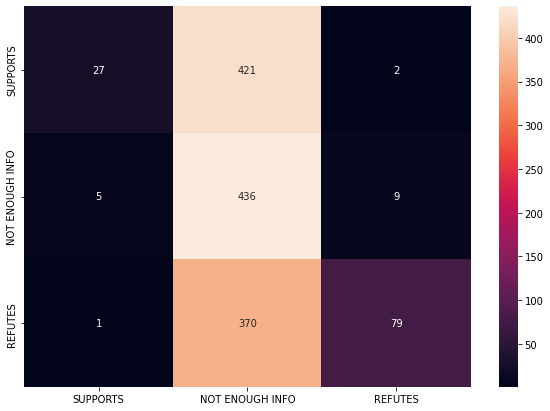

In [ ]:
cm = confusion_matrix(gt, preds)
classes = [*getLabels()]
df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g')